In [472]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt

In [494]:
class QRSDetector():
    """QRS complex detector."""

    def __init__(self, file):
        """Variables initialization."""
        ## Data file path.
        self.file = file
        
        ## Signal processing variables.
        self.raw_signal = np.array([])
        self.filtered = np.array([])
        self.differentiated_signal = np.array([])
        self.squared_signal = np.array([])
        self.integrated_signal = np.array([])

        # Peak detection variables.
        self.fiducial_mark_val_i = np.array([])
        self.fiducial_mark_idx = np.array([])

        ## Peak thresholding variables.
        self.qrs_peak_i = np.array([])
        self.noise_peak_i = np.array([])
        
        ## Integrated signal detection and thresholding params.
        self.spk_i = 0.0 
        self.npk_i = 0.0 
        self.threshold_i_1 = 0.0
        self.threshold_i_2 = 0.0 

        ## Params.
        self.signal_freq = 523 
        self.integration_window = 75
        self.peak_width_low = 10
        self.peak_width_high = 15
        
    ## Tool methods.
    def butter_bandpass_filter(self, data, lowcut, highcut, signal_freq, order):
        """Constructs signal filter."""
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(order, [low, high], btype='band')
        y = lfilter(b, a, data)
        return y
    
    ## Data processing methods.
    def load_data(self):
        """Loads and cleans data."""
        with open(self.file) as f:
            content = f.readlines()
        content = content[0:400]
        for line in content:
            self.raw_signal = np.append(self.raw_signal, float(line.rstrip().split(';')[1]))

    def process_data(self):
        """Process received data."""
        ## Signal filtering - pass band 0-15 Hz.
        self.filtered_signal = self.butter_bandpass_filter(self.raw_signal, lowcut=0.0, 
                                                           highcut=15.0, signal_freq=self.signal_freq, order=1)
        
        ## Derivative - provides QRS slope info.
        self.differentiated_signal = np.ediff1d(self.filtered_signal) 

        ## Squaring.
        self.squared_signal = self.differentiated_signal**2
        
        ## Moving-window integration.
        self.integrated_signal = np.convolve(self.squared_signal, np.ones(self.integration_window))

        ## Fiducial mark - peak detection - integrated signal
        self.peaks_indices = find_peaks_cwt(self.integrated_signal, 
                                            np.arange(self.peak_width_low, self.peak_width_high), noise_perc=0.1)
        
        for peak_index in self.peaks_indices:
            self.fiducial_mark_idx = np.append(self.fiducial_mark_idx, peak_index)
            self.fiducial_mark_val_i = np.append(self.fiducial_mark_val_i, self.integrated_signal[peak_index])
    
    def threshold_peaks(self):
        """Thresholding detect peaks - integrated signal."""
        for peak_idx, peak_val_i in zip(self.fiducial_mark_idx, self.fiducial_mark_val_i):
            if peak_val_i > self.threshold_i_1:
                self.spk_i = 0.125 * peak_val_i + 0.875 * self.spk_i
                self.qrs_peak_i = np.append(self.qrs_peak_i, peak_idx)
            else:
                self.npk_i = 0.125 * peak_val_i + 0.875 * self.npk_i
                self.noise_peak_i = np.append(self.noise_peak_i, peak_idx)

            self.threshold_i_1 = self.npk_i + 0.25 * (self.spk_i - self.npk_i)
            self.threshold_i_2 = 0.5 * self.threshold_i_1 
        
    ## Visualization methods.
    def plot_everything(self):
        ## Plot everything.
        plt.figure(figsize=(15,18))
        plt.subplot(711)
        plt.plot(self.raw_signal, label="Original signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(712)
        plt.plot(self.filtered_signal, label="Filtered signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(713)
        plt.plot(self.differentiated_signal, label="Differentiated signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        plt.subplot(714)
        plt.plot(self.squared_signal, label="Squared signal", color="salmon")
        plt.grid(True)
        plt.axis("tight")

        fiducial_mark_indication_i = [0] * len(self.integrated_signal)
        for peak_idx_i, peak_val_i in zip(self.fiducial_mark_idx, self.fiducial_mark_val_i):
            fiducial_mark_indication_i[int(peak_idx_i)] = peak_val_i
        plt.subplot(715)
        plt.plot(self.integrated_signal, label="Integrated signal", color="salmon")
        plt.plot(fiducial_mark_indication_i, 'k.')
        plt.grid(True)
        plt.axis("tight")
        
        qrs_peak_indication_i = [0] * len(self.integrated_signal)
        for peak_i in self.qrs_peak_i:
            qrs_peak_indication_i[int(peak_i)] = self.raw_signal[int(peak_i)]
        noise_peak_indication_i = [0] * len(self.integrated_signal)
        for peak_i in self.noise_peak_i:
            noise_peak_indication_i[int(peak_i)] = self.raw_signal[int(peak_i)]
            
        plt.subplot(716)
        plt.plot(self.raw_signal, label="Integrated signal", color="salmon")
        plt.plot(qrs_peak_indication_i, 'k.')
        plt.plot(noise_peak_indication_i, 'yo')
        plt.grid(True)
        plt.axis("tight")
        
        plt.subplot(717)
        plt.plot(self.raw_signal, 'k.', label="Integrated signal", color="salmon")
        plt.plot(qrs_peak_indication_i, 'k.')
        plt.plot(noise_peak_indication_i, 'yo')
        plt.grid(True)
        plt.axis("tight")

IndexError: index 400 is out of bounds for axis 0 with size 400

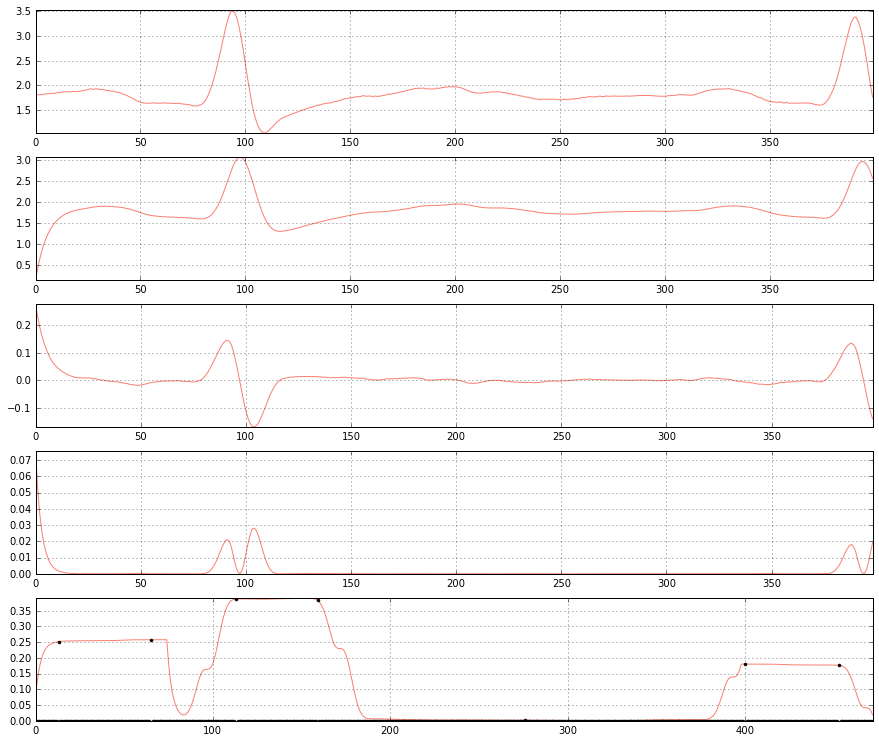

In [495]:
qrs_detector = QRSDetector("data523hz/pulse1.csv")
qrs_detector.load_data()
qrs_detector.process_data()
qrs_detector.threshold_peaks()
qrs_detector.plot_everything()